**Final Project**

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import imageio
import random
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import History 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# set random seed
seed = 10
random.seed(seed)

In C:\Users\User\anaconda3\envs\Perc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\anaconda3\envs\Perc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\anaconda3\envs\Perc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\User\anaconda3\envs\Perc\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\User\anaconda3\envs\Perc\lib\site-packages\m

## Calibrate and Rectify the stereo input

### Load images and extract object and image points

In [2]:
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

images_l = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_Calibration/Stereo_calibration_images/left-*.png')
images_r = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_Calibration/Stereo_calibration_images/right-*.png')

In [3]:
left_count = len(images_l)
print('# of left images:', left_count)
right_count = len(images_r)
print('# of left images:', right_count)

# of left images: 50
# of left images: 50


In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
for i in range(left_count):
    imgL = cv2.imread(images_l[i])
    imgR = cv2.imread(images_r[i])
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    outputL = imgL.copy()
    outputR = imgR.copy()

    retR, cornersR =  cv2.findChessboardCorners(outputR,(nb_vertical,nb_horizontal),None)
    retL, cornersL = cv2.findChessboardCorners(outputL,(nb_vertical,nb_horizontal),None)

    if retR and retL:
        objpoints.append(objp)
        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)
        
        cv2.cornerSubPix(grayR,cornersR,(11,11),(-1,-1),criteria)
        cv2.cornerSubPix(grayL,cornersL,(11,11),(-1,-1),criteria)
        cv2.drawChessboardCorners(outputR,(9,6),cornersR,retR)
        cv2.drawChessboardCorners(outputL,(9,6),cornersL,retL)
        cv2.imshow('cornersR',outputR)
        cv2.imshow('cornersL',outputL)
        cv2.waitKey(150)
        
cv2.destroyAllWindows()

### Calibrate cameras, Rectify &' Undistort the images

In [5]:
# calibrating left and right camera
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, None)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, None)

In [6]:
# get new optimal camera matrix
#hL,  wL = grayL.shape[:2]
#newcameramtxL, roiL = cv2.getOptimalNewCameraMatrix(mtxL,distL,(wL,hL),1,(wL,hL))
#hR,  wR = grayR.shape[:2]
#newcameramtxR, roiR = cv2.getOptimalNewCameraMatrix(mtxR,distR,(wR,hR),1,(wR,hR))

In [7]:
flags = 0
#flags |= cv2.CALIB_FIX_INTRINSIC
flags |= cv2.CALIB_USE_INTRINSIC_GUESS
#flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
flags |= cv2.CALIB_FIX_FOCAL_LENGTH
flags |= cv2.CALIB_FIX_ASPECT_RATIO
flags |= cv2.CALIB_SAME_FOCAL_LENGTH
flags |= cv2.CALIB_ZERO_TANGENT_DIST
#flags |= cv2.CALIB_FIX_K1,...,cv2.CALIB_FIX_K6
flags |= cv2.CALIB_RATIONAL_MODEL
criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

In [8]:
# This step is performed to calculate the transformation between the two cameras and calculate Essential and Fundamenatl matrix
ret, newcameramtxL, distL, newcameramtxR, distR, R, T, E, F = \
    cv2.stereoCalibrate(objpoints, 
                        imgpointsL, imgpointsR, 
                        mtxL, distL, mtxR, distR, 
                        grayL.shape,
                        criteria=criteria_stereo,
                        flags=flags)

In [9]:
# Once we know the transformation between the two cameras we can perform stereo rectification
R1, R2, P1, P2, Q, roi_left, roi_right = \
    cv2.stereoRectify(newcameramtxL, distL, 
                      newcameramtxR, distR,
                      grayL.shape[::-1], 
                      R, T, 
                      flags = cv2.CALIB_ZERO_DISPARITY,
                      alpha = -1)

In [10]:
# Compute the mapping required to obtain the undistorted rectified stereo image pair
xmapL, ymapL = cv2.initUndistortRectifyMap(newcameramtxL, distL, 
                                           R1, P1, 
                                           grayL.shape[::-1], 
                                           cv2.CV_16SC2)
xmapR, ymapR = cv2.initUndistortRectifyMap(newcameramtxR, distR, 
                                           R2, P2, 
                                           grayR.shape[::-1], 
                                           cv2.CV_16SC2)

In [11]:
imgL = cv2.imread('C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_Calibration/Stereo_calibration_images/left-0033.png')
imgR = cv2.imread('C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_Calibration/Stereo_calibration_images/right-0033.png')

In [12]:
rectL = cv2.remap(imgL, 
                  xmapL, ymapL, 
                  cv2.INTER_LANCZOS4, 
                  cv2.BORDER_CONSTANT, 
                  0)
rectR = cv2.remap(imgR, 
                  xmapR, ymapR, 
                  cv2.INTER_LANCZOS4, 
                  cv2.BORDER_CONSTANT, 
                  0)

Text(0.5, 1.0, 'Right image')

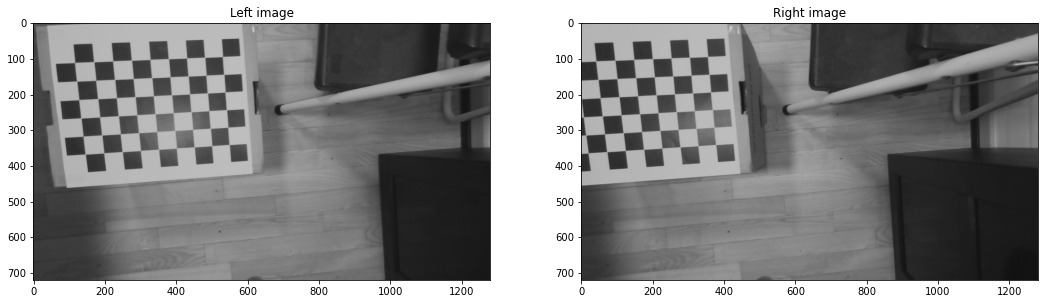

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(rectL, cmap='gray')
ax[0].set_title('Left image')
ax[1].imshow(rectR, cmap='gray')
ax[1].set_title('Right image')

In [16]:
out = rectR.copy()
out[:,:,0] = rectR[:,:,0]
out[:,:,1] = rectR[:,:,1]
out[:,:,2] = rectL[:,:,2]
cv2.imshow("Output image", out)
cv2.waitKey(1000)
cv2.destroyAllWindows()

### Save the undistorted and rectified images of the test data

In [17]:
dist_occ_path = 'C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_conveyor_with_occlusions/'
dist_path = 'C:/Users/User/Desktop/courses/PFAS/final_project/Stereo_conveyor_without_occlusions/'
dist_list = [dist_occ_path, dist_path]

In [25]:
for j in range(2):
    path = dist_list[j]
    
    templ = path + 'left/*.png'
    tempr = path + 'right/*.png'
    images_l = glob.glob(templ)
    images_r = glob.glob(tempr)
    for i in range(len(images_l)):
        imgL = cv2.imread(images_l[i])
        imgR = cv2.imread(images_r[i])

        rectL = cv2.remap(imgL, 
                          xmapL, ymapL, 
                          cv2.INTER_LANCZOS4, 
                          cv2.BORDER_CONSTANT, 
                          0)
        rectR = cv2.remap(imgR, 
                          xmapR, ymapR, 
                          cv2.INTER_LANCZOS4, 
                          cv2.BORDER_CONSTANT, 
                          0)
        
        if j == 0 :
            str_prefix = 'with_'
        else:
            str_prefix = 'without_'
        
        rectL = cv2.resize(rectL, (256, 256))
        rectL_str = str(i)+'.jpg'
        cv2.imwrite(path + 'left_undist/resized/left_' + str_prefix + rectL_str, rectL)

        rectR = cv2.resize(rectR, (256, 256))
        rectR_str = str(i)+'.jpg'
        cv2.imwrite(path + 'right_undist/resized/right_' + str_prefix + rectR_str, rectR)

### Resize and save the cropped, undistorted test and train frames (cropping was done manually, this isn't mandatory to run)

In [26]:
train_frames_path = 'C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped/'
test_frames_path = 'C:/Users/User/Desktop/courses/PFAS/final_project/test_frames/cropped/'
dist_list = [train_frames_path, test_frames_path]

In [30]:
for j in range(2):
    path = dist_list[j]
    
    images = glob.glob(path + '*.jpg')
    for i in range(len(images)):
        img = cv2.imread(images[i])
        
        img = cv2.resize(img, (256, 256))
        img_str = str(i)+'.jpg'
        cv2.imwrite(path + 'resized/' + img_str, img)

C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_1003.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_1177.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_1381.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_139.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_441.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_495.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\left_without_691.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\right_with_1013.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\right_with_1097.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\right_with_1217.jpg
C:/Users/User/Desktop/courses/PFAS/final_project/train_frames/cropped\right_with_1319.jpg


### Epipolar geometry (not necessary, you can run it after 1.2 to check the results)

In [42]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

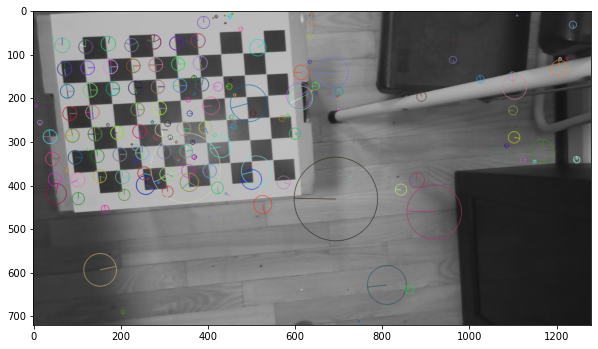

In [43]:
imgL = rectL
imgR = rectR

imgL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

kp_img = cv2.drawKeypoints(imgL, kpR, imgL, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

In [44]:
bf = cv2.BFMatcher()
matches = bf.match(desL, desR)

In [45]:
# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

In [46]:
nb_matches = 150
good = []
ptsL = []
ptsR = []

for m in matches[:nb_matches]:
    good.append(m)
    ptsL.append(kpL[m.queryIdx].pt)
    ptsR.append(kpR[m.trainIdx].pt)
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
    
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC)

# We select only inlier points
ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

In [47]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 2 ,F)
linesL = linesL.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, F)
linesR = linesR.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

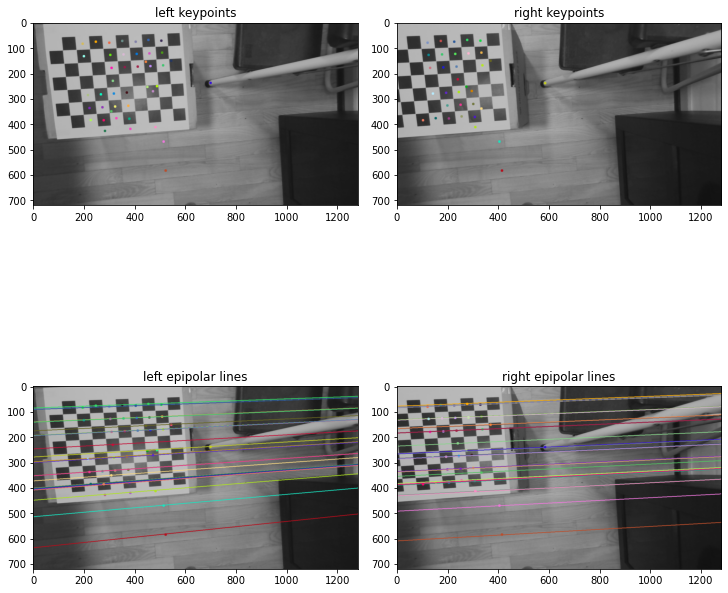

In [48]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

## Process the input images to detect objects on the conveyor and track them in 3D, even under occlusions.

## Train a machine learning system that can classify unseen images into the 3 classes (cups, books and boxes) based either on 2D or 3D data.

### Data preprocessing

Our dataset contains 231 images of each of the following categories: Book, Box, Cup.<br/>
We collected images from the following resources: google images, pinterest, [imagenet](http://www.image-net.org/) , [open images](https://opensource.google/projects/open-images-dataset).<br/>
We also took photos of objects ourselves, as well as asked friends and family to do the same, in order to get a rich dataset.

#### Check amount of data

##### JPG files + JPEG imaged

In [32]:
books_jpg = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/books/*.jpg')
boxes_jpg = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/boxes/*.jpg')
cups_jpg = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/cups/*.jpg')
cups_jpeg = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/cups/*.JPEG')

In [33]:
print(len(books_jpg), len(boxes_jpg), len(cups_jpg), len(cups_jpeg))

123 117 102 12


##### PNG files

In [34]:
books_png = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/books/*.png')
boxes_png = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/boxes/*.png')
cups_png = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/cups/*.png')

In [35]:
print(len(books_png), len(boxes_png), len(cups_png))

7 19 21


In [36]:
num_images_per_class = len(books_png) + len(books_jpg)
print(len(books_png) + len(books_jpg), len(boxes_png) + len(boxes_jpg), len(cups_png) + len(cups_jpg) + len(cups_jpeg))

130 136 135


In [37]:
num_images = len(books_png) + len(books_jpg) + len(boxes_png) + len(boxes_jpg) + len(cups_png) + len(cups_jpg) + len(cups_jpeg)
print("Total number of images:", num_images)

Total number of images: 401


#### Create 3 seperate list with all the images

In [38]:
type(books_png)

list

In [39]:
books = []
boxes = []
cups = []

books.extend(books_png)
books.extend(books_jpg)

boxes.extend(boxes_png)
boxes.extend(boxes_jpg)

cups.extend(cups_png)
cups.extend(cups_jpg)
cups.extend(cups_jpeg)

In [40]:
print(len(books), len(boxes), len(cups))

130 136 135


In [41]:
num_images = max(len(books), len(boxes), len(cups))

#### Read and resize images so that all have the same size

In [43]:
images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates"
os.chdir(images_dir)
for i in range(num_images):
    try:
        book_img = Image.open(books[i])
        book_img = book_img.convert('RGB')
        new_book_image = book_img.resize((256, 256))
        book_str = 'resized/book_'+str(i)+'.jpg'
        new_book_image.save(book_str)
    except:
        pass
    
    try:
        box_img = Image.open(boxes[i])
        box_img = box_img.convert('RGB')
        new_box_image = box_img.resize((256, 256))
        box_str = 'resized/box_'+str(i)+'.jpg'
        new_box_image.save(box_str)
    except:
        pass
    
    try:
        cup_img = Image.open(cups[i])
        cup_img = cup_img.convert('RGB')
        new_cup_image = cup_img.resize((256, 256))
        cup_str = 'resized/cup_'+str(i)+'.jpg'
        new_cup_image.save(cup_str)
    except:
        pass

In [230]:
print(book_img.size) # Output: (1920, 1280)
print(new_book_image.size) # Output: (256, 256)

(980, 694)
(256, 256)


#### Create augmented data

In [44]:
resized_images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/resized"
os.chdir(resized_images_dir)

In [45]:
datagen = ImageDataGenerator( 
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    zca_epsilon=1e-06,
    rotation_range=90,
    width_shift_range=0,
    height_shift_range=0,
    brightness_range=[0.1, 2],
    shear_range=0,
    zoom_range=[0.9,1],
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format="channels_last",
    validation_split=0,
    dtype=None,
)

In [47]:
for image_path in glob.glob('*.jpg'):
    img = load_img(image_path) 
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0
    
    # generate 5 new augmented images
    if "book" in image_path:
        prefix = "book_aug"
    elif "box" in image_path:
        prefix = "box_aug"
    else:
        prefix = "cup_aug"
        
    # Save x augmented images for every image
    aug_thresh = 8
    for batch in datagen.flow(x, 
                              batch_size = 1, 
                              save_to_dir = "augmented",  
                              save_prefix = prefix,
                              save_format = 'jpg',
                              subset = 'training') :
        i += 1
        if i > aug_thresh: 
            break

#### Pass data to a list and add "class" attribute.
**Reminder** *: 0 : book, 1 : box, 2 : cup*

In [48]:
# create empty list to store 3d image data
df_list = []

# read all the resized .jpg files
resized_images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/resized"
aug_images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/resized/augmented"
for images_dir in [resized_images_dir, aug_images_dir]:
    os.chdir(images_dir)
    for image_path in glob.glob('*.jpg'):
        image = imageio.imread(image_path)

        # check that the dimensions of the picture are ok
        if (image.shape[0] != 256):
            print ('Wrong height pixels')
            break
        elif (image.shape[1] != 256):
            print ('Wrong width pixels')
            break
        elif (image.shape[2] != 3):
            print ('Wrong # of colors')
            break

        # flatten image array
        image = image.flatten()

        # add "class" - target column
        if "book" in image_path:
            image = np.append(image,np.array([0]),0)
        elif "box" in image_path:
            image = np.append(image,np.array([1]),0)
        else:
            image = np.append(image,np.array([2]),0)

        df_list.append(image)
    
print(image.shape)

(196609,)


In [49]:
np.shape(df_list)

(3787, 196609)

In [50]:
df_list[0:2]

[array([102,  66,  42, ...,  36,  34,   0]),
 array([146, 121, 116, ..., 221, 220,   0])]

In [51]:
X = [row[:-1] for row in df_list]
X = [temp/255 for temp in X]
y = [row[-1] for row in df_list]

#### Reshape X data to a CNN compatible form, 

In [52]:
# reshape our data as a CNN network wants them
X = np.reshape(X, (np.shape(X)[0], 256, 256, 3))
np.shape(X)

(3787, 256, 256, 3)

#### One-hot-encode y
- 1st column : books
- 2nd column : boxes
- 3rd column : cups

In [53]:
y_onehot = np.zeros((np.size(y), np.max(y)+1))
y_onehot[np.arange(np.size(y)),y] = 1

In [54]:
y_onehot # we will not use this instantly, however (we redo the one hot encoding after the train/val/test split)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

#### Split Training, Test -> 0.8, 0.2

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=seed)

**Plot one example image**

In [56]:
np.shape(X)

(3787, 256, 256, 3)

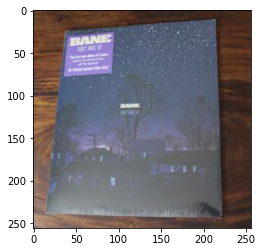

In [57]:
plt.imshow((X[0][:,:,:]*255).astype('uint8'))

**Validate that our train/test split is somewhat reasonably weighted across our target classes**

In [58]:
book_count = [row[0] for row in y_train].count(1)
box_count = [row[1] for row in y_train].count(1)
cup_count = [row[2] for row in y_train].count(1)
print("Train \nBooks: {} , Boxes: {} , Cups: {}".format(book_count, box_count, cup_count))

Train 
Books: 966 , Boxes: 1061 , Cups: 1002


In [59]:
book_count = [row[0] for row in y_val].count(1)
box_count = [row[1] for row in y_val].count(1)
cup_count = [row[2] for row in y_val].count(1)
print("Validation \nBooks: {} , Boxes: {} , Cups: {}".format(book_count, box_count, cup_count))

Validation 
Books: 257 , Boxes: 222 , Cups: 279


### Build our ML system

#### Create our model and fit without data augmentation

In [60]:
input_shape = (256, 256, 3)

In [61]:
# define optimizer
optimizer = optimizers.Adam(lr=0.01)

# Define callback for learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=3, 
                              verbose=1,
                              mode = 'auto',
                              min_lr=0.0000001)

In [62]:
# basis of convolutional network
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# pass to fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer = 'Adam',
              loss = "categorical_crossentropy", 
              metrics=["accuracy"])

In [63]:
# fit model
batch_size = 32
epochs = 20
h = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              batch_size=batch_size, 
              epochs=epochs, 
              verbose=1,
              callbacks = [reduce_lr])

Train on 3029 samples, validate on 758 samples
Epoch 1/20
3029/3029 [==============================] - 121s 40ms/step - loss: 1.4214 - accuracy: 0.5553 - val_loss: 0.7201 - val_accuracy: 0.7058
Epoch 2/20
3029/3029 [==============================] - 109s 36ms/step - loss: 0.7443 - accuracy: 0.6867 - val_loss: 0.8007 - val_accuracy: 0.6530
Epoch 3/20
3029/3029 [==============================] - 110s 36ms/step - loss: 0.5756 - accuracy: 0.7547 - val_loss: 0.6938 - val_accuracy: 0.7203
Epoch 4/20
3029/3029 [==============================] - 111s 37ms/step - loss: 0.3983 - accuracy: 0.8462 - val_loss: 0.6030 - val_accuracy: 0.7507
Epoch 5/20
3029/3029 [==============================] - 112s 37ms/step - loss: 0.2657 - accuracy: 0.8983 - val_loss: 0.7415 - val_accuracy: 0.7507
Epoch 6/20
3029/3029 [==============================] - 113s 37ms/step - loss: 0.1845 - accuracy: 0.9300 - val_loss: 0.7563 - val_accuracy: 0.7797
Epoch 7/20
3029/3029 [==============================] - 114s 38ms/step 

#### Grid search (doesn't work well, takes TOO MUCH time)

In [285]:
def create_model(optimizer = optimizers.Adam(lr=0.01)):
    # basis of convolutional network
    model = models.Sequential()
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # pass to fully connected layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer = optimizer,
                  loss = "categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

In [287]:
# define the grid search parameters
grid_model = KerasClassifier(build_fn=create_model, verbose=1)
batch_size = [16, 32, 64]
epochs = [15]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_result = grid.fit(X, y_onehot)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/15
2888/2888 [==============================] - 107s 37ms/step - loss: 1.0196 - accuracy: 0.5111
Epoch 2/15
2888/2888 [==============================] - 100s 35ms/step - loss: 0.8665 - accuracy: 0.6188
Epoch 3/15
2888/2888 [==============================] - 100s 35ms/step - loss: 0.7495 - accuracy: 0.6877
Epoch 4/15
2888/2888 [==============================] - 101s 35ms/step - loss: 0.6458 - accuracy: 0.7420
Epoch 5/15
2888/2888 [==============================] - 100s 35ms/step - loss: 0.5715 - accuracy: 0.7732
Epoch 6/15
2888/2888 [==============================] - 100s 35ms/step - loss: 0.5147 - accuracy: 0.8026
Epoch 7/15
2888/2888 [==============================] - 101s 35ms/step - loss: 0.4624 - accuracy: 0.8248
Epoch 8/15
2888/2888 [==============================] - 100s 35ms/step - loss: 0.4250 - accuracy: 0.8400
Epoch 9/15
2888/2888 [==============================] - 101s 35ms/step - loss: 0.3687 - accuracy: 0.8663
Epoch 10/15
2888/2888 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 103s 36ms/step - loss: 0.9509 - accuracy: 0.5562
Epoch 2/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.7910 - accuracy: 0.6715
Epoch 3/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.6860 - accuracy: 0.7217
Epoch 4/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.5882 - accuracy: 0.7722
Epoch 5/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.5456 - accuracy: 0.7844
Epoch 6/15
2889/2889 [==============================] - 98s 34ms/step - loss: 0.4840 - accuracy: 0.8210
Epoch 7/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.4299 - accuracy: 0.8325
Epoch 8/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.3833 - accuracy: 0.8529
Epoch 9/15
2889/2889 [==============================] - 97s 33ms/step - loss: 0.3314 - accuracy: 0.8823
Epoch 10/15
2889/2889 [==============================] - 97s 33

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 128s 44ms/step - loss: 0.9772 - accuracy: 0.5106
Epoch 2/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.8250 - accuracy: 0.6376
Epoch 3/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.7330 - accuracy: 0.6816
Epoch 4/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.6391 - accuracy: 0.7407
Epoch 5/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.5700 - accuracy: 0.7702
Epoch 6/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.5054 - accuracy: 0.7937
Epoch 7/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.4355 - accuracy: 0.8242
Epoch 8/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.3863 - accuracy: 0.8519
Epoch 9/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.3315 - accuracy: 0.8740
Epoch 10/15
2889/2889 [==============================] - 96s 33

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 116s 40ms/step - loss: 0.9980 - accuracy: 0.5147
Epoch 2/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.8356 - accuracy: 0.6296
Epoch 3/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.7385 - accuracy: 0.6874
Epoch 4/15
2889/2889 [==============================] - 98s 34ms/step - loss: 0.6743 - accuracy: 0.7196
Epoch 5/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.6112 - accuracy: 0.7466
Epoch 6/15
2889/2889 [==============================] - 97s 34ms/step - loss: 0.5696 - accuracy: 0.7674
Epoch 7/15
2889/2889 [==============================] - 98s 34ms/step - loss: 0.5178 - accuracy: 0.7944
Epoch 8/15
2889/2889 [==============================] - 98s 34ms/step - loss: 0.4599 - accuracy: 0.8176
Epoch 9/15
2889/2889 [==============================] - 98s 34ms/step - loss: 0.4105 - accuracy: 0.8435
Epoch 10/15
2889/2889 [==============================] - 98s 34

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.9560 - accuracy: 0.5680
Epoch 2/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.8048 - accuracy: 0.6480
Epoch 3/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.7129 - accuracy: 0.6937
Epoch 4/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.6424 - accuracy: 0.7342
Epoch 5/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.5920 - accuracy: 0.7691
Epoch 6/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.5232 - accuracy: 0.7889
Epoch 7/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.4884 - accuracy: 0.8096
Epoch 8/15
2889/2889 [==============================] - 95s 33ms/step - loss: 0.4289 - accuracy: 0.8304
Epoch 9/15
2889/2889 [==============================] - 96s 33ms/step - loss: 0.3865 - accuracy: 0.8442
Epoch 10/15
2889/2889 [==============================] - 95s 33m

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2888/2888 [==============================] - 175s 61ms/step - loss: 1.6653 - accuracy: 0.5474
Epoch 2/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.7172 - accuracy: 0.7123
Epoch 3/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.5038 - accuracy: 0.8092
Epoch 4/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.3500 - accuracy: 0.8712
Epoch 5/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.2451 - accuracy: 0.9148
Epoch 6/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.1860 - accuracy: 0.9398
Epoch 7/15
2888/2888 [==============================] - 128s 44ms/step - loss: 0.1329 - accuracy: 0.9578
Epoch 8/15
2888/2888 [==============================] - 128s 44ms/step - loss: 0.1137 - accuracy: 0.9678
Epoch 9/15
2888/2888 [==============================] - 129s 45ms/step - loss: 0.0940 - accuracy: 0.9733
Epoch 10/15
2888/2888 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 153s 53ms/step - loss: 1.1126 - accuracy: 0.5898
Epoch 2/15
2889/2889 [==============================] - 129s 44ms/step - loss: 0.6318 - accuracy: 0.7473
Epoch 3/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.4365 - accuracy: 0.8349
Epoch 4/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.3019 - accuracy: 0.8858
Epoch 5/15
2889/2889 [==============================] - 128s 44ms/step - loss: 0.2153 - accuracy: 0.9169
Epoch 6/15
2889/2889 [==============================] - 129s 44ms/step - loss: 0.1648 - accuracy: 0.9495
Epoch 7/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.1235 - accuracy: 0.9598
Epoch 8/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.1118 - accuracy: 0.9668
Epoch 9/15
2889/2889 [==============================] - 128s 44ms/step - loss: 0.1018 - accuracy: 0.9740
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 150s 52ms/step - loss: 1.1942 - accuracy: 0.5947
Epoch 2/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.5982 - accuracy: 0.7695
Epoch 3/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.4347 - accuracy: 0.8494
Epoch 4/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.3054 - accuracy: 0.8917
Epoch 5/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.2372 - accuracy: 0.9238
Epoch 6/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.1626 - accuracy: 0.9463
Epoch 7/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.1045 - accuracy: 0.9654
Epoch 8/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.0948 - accuracy: 0.9747
Epoch 9/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.0636 - accuracy: 0.9844
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 170s 59ms/step - loss: 1.2625 - accuracy: 0.5767
Epoch 2/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.6451 - accuracy: 0.7456
Epoch 3/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.4688 - accuracy: 0.8179
Epoch 4/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.3558 - accuracy: 0.8681
Epoch 5/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.2324 - accuracy: 0.9200
Epoch 6/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1969 - accuracy: 0.9360
Epoch 7/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1185 - accuracy: 0.9623
Epoch 8/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1313 - accuracy: 0.9716
Epoch 9/15
2889/2889 [==============================] - 129s 45ms/step - loss: 0.0994 - accuracy: 0.9775
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 175s 61ms/step - loss: 1.3329 - accuracy: 0.6120
Epoch 2/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.6566 - accuracy: 0.7473
Epoch 3/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.5136 - accuracy: 0.8086
Epoch 4/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.3977 - accuracy: 0.8660
Epoch 5/15
2889/2889 [==============================] - 131s 45ms/step - loss: 0.2585 - accuracy: 0.9155
Epoch 6/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1848 - accuracy: 0.9380
Epoch 7/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1898 - accuracy: 0.9467
Epoch 8/15
2889/2889 [==============================] - 130s 45ms/step - loss: 0.1813 - accuracy: 0.9571
Epoch 9/15
2889/2889 [==============================] - 131s 45ms/step - loss: 0.1414 - accuracy: 0.9675
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2888/2888 [==============================] - 178s 62ms/step - loss: 3.6029 - accuracy: 0.5277
Epoch 2/15
2888/2888 [==============================] - 120s 41ms/step - loss: 0.7543 - accuracy: 0.6801
Epoch 3/15
2888/2888 [==============================] - 119s 41ms/step - loss: 0.5958 - accuracy: 0.7559
Epoch 4/15
2888/2888 [==============================] - 120s 42ms/step - loss: 0.4682 - accuracy: 0.8141
Epoch 5/15
2888/2888 [==============================] - 120s 41ms/step - loss: 0.3448 - accuracy: 0.8677
Epoch 6/15
2888/2888 [==============================] - 120s 41ms/step - loss: 0.2691 - accuracy: 0.9072
Epoch 7/15
2888/2888 [==============================] - 119s 41ms/step - loss: 0.1879 - accuracy: 0.9394
Epoch 8/15
2888/2888 [==============================] - 120s 41ms/step - loss: 0.1382 - accuracy: 0.9498
Epoch 9/15
2888/2888 [==============================] - 119s 41ms/step - loss: 0.0929 - accuracy: 0.9747
Epoch 10/15
2888/2888 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 178s 62ms/step - loss: 5.0379 - accuracy: 0.5812
Epoch 2/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.6817 - accuracy: 0.7210
Epoch 3/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.5390 - accuracy: 0.7760
Epoch 4/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.4447 - accuracy: 0.8290
Epoch 5/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.3473 - accuracy: 0.8785
Epoch 6/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.2579 - accuracy: 0.9093
Epoch 7/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.2020 - accuracy: 0.9263
Epoch 8/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.1570 - accuracy: 0.9467
Epoch 9/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.1259 - accuracy: 0.9595
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 151s 52ms/step - loss: 7.4544 - accuracy: 0.5725
Epoch 2/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.6528 - accuracy: 0.7283
Epoch 3/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.5234 - accuracy: 0.7930
Epoch 4/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.4185 - accuracy: 0.8356
Epoch 5/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.3994 - accuracy: 0.8595
Epoch 6/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.2774 - accuracy: 0.8986
Epoch 7/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.2014 - accuracy: 0.9294
Epoch 8/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.1550 - accuracy: 0.9505
Epoch 9/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.1197 - accuracy: 0.9619
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 166s 57ms/step - loss: 4.0149 - accuracy: 0.4922
Epoch 2/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.7892 - accuracy: 0.6390
Epoch 3/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.6216 - accuracy: 0.7397
Epoch 4/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.4928 - accuracy: 0.8017
Epoch 5/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.3966 - accuracy: 0.8429
Epoch 6/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.2924 - accuracy: 0.8865
Epoch 7/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.2366 - accuracy: 0.9100
Epoch 8/15
2889/2889 [==============================] - 118s 41ms/step - loss: 0.1776 - accuracy: 0.9391
Epoch 9/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.1358 - accuracy: 0.9571
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 175s 61ms/step - loss: 1.6764 - accuracy: 0.6175
Epoch 2/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.6530 - accuracy: 0.7300
Epoch 3/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.4973 - accuracy: 0.7985
Epoch 4/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.3725 - accuracy: 0.8591
Epoch 5/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.2741 - accuracy: 0.8958
Epoch 6/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.1878 - accuracy: 0.9356
Epoch 7/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.1166 - accuracy: 0.9637
Epoch 8/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.0837 - accuracy: 0.9727
Epoch 9/15
2889/2889 [==============================] - 119s 41ms/step - loss: 0.0668 - accuracy: 0.9823
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2888/2888 [==============================] - 246s 85ms/step - loss: 1.1187 - accuracy: 0.5246
Epoch 2/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.7033 - accuracy: 0.7019
Epoch 3/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.5202 - accuracy: 0.7846
Epoch 4/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.3673 - accuracy: 0.8587
Epoch 5/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.2484 - accuracy: 0.9131
Epoch 6/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.1584 - accuracy: 0.9439
Epoch 7/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.0922 - accuracy: 0.9723
Epoch 8/15
2888/2888 [==============================] - 174s 60ms/step - loss: 0.0665 - accuracy: 0.9775
Epoch 9/15
2888/2888 [==============================] - 173s 60ms/step - loss: 0.0411 - accuracy: 0.9844
Epoch 10/15
2888/2888 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 265s 92ms/step - loss: 1.1491 - accuracy: 0.5607
Epoch 2/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.7118 - accuracy: 0.7072
Epoch 3/15
2889/2889 [==============================] - 174s 60ms/step - loss: 0.5170 - accuracy: 0.7913
Epoch 4/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.3571 - accuracy: 0.8719
Epoch 5/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.2487 - accuracy: 0.9100
Epoch 6/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.1446 - accuracy: 0.9512
Epoch 7/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.0707 - accuracy: 0.9789
Epoch 8/15
2889/2889 [==============================] - 174s 60ms/step - loss: 0.0559 - accuracy: 0.9844
Epoch 9/15
2889/2889 [==============================] - 173s 60ms/step - loss: 0.0400 - accuracy: 0.9893
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 200s 69ms/step - loss: 1.0693 - accuracy: 0.5614
Epoch 2/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.7083 - accuracy: 0.7013
Epoch 3/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.5257 - accuracy: 0.7878
Epoch 4/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.3728 - accuracy: 0.8525
Epoch 5/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.2595 - accuracy: 0.9138
Epoch 6/15
2889/2889 [==============================] - 174s 60ms/step - loss: 0.1618 - accuracy: 0.9453
Epoch 7/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.1169 - accuracy: 0.9637
Epoch 8/15
2889/2889 [==============================] - 174s 60ms/step - loss: 0.0563 - accuracy: 0.9820
Epoch 9/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.0330 - accuracy: 0.9900
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 235s 81ms/step - loss: 1.0860 - accuracy: 0.5192
Epoch 2/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.7291 - accuracy: 0.6964
Epoch 3/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.5230 - accuracy: 0.7885
Epoch 4/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.3638 - accuracy: 0.8622
Epoch 5/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.2451 - accuracy: 0.9007
Epoch 6/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.1496 - accuracy: 0.9495
Epoch 7/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.0983 - accuracy: 0.9640
Epoch 8/15
2889/2889 [==============================] - 175s 60ms/step - loss: 0.0488 - accuracy: 0.9827
Epoch 9/15
2889/2889 [==============================] - 175s 61ms/step - loss: 0.0469 - accuracy: 0.9872
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 232s 80ms/step - loss: 1.3221 - accuracy: 0.5912
Epoch 2/15
2889/2889 [==============================] - 176s 61ms/step - loss: 0.7016 - accuracy: 0.7068
Epoch 3/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.5506 - accuracy: 0.7840
Epoch 4/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.4051 - accuracy: 0.8394
Epoch 5/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.2796 - accuracy: 0.8958
Epoch 6/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.1944 - accuracy: 0.9294
Epoch 7/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.1191 - accuracy: 0.9609
Epoch 8/15
2889/2889 [==============================] - 177s 61ms/step - loss: 0.0733 - accuracy: 0.9747
Epoch 9/15
2889/2889 [==============================] - 178s 62ms/step - loss: 0.0535 - accuracy: 0.9841
Epoch 10/15
2889/2889 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2888/2888 [==============================] - 207s 72ms/step - loss: 1.1592 - accuracy: 0.5793
Epoch 2/15
2888/2888 [==============================] - 150s 52ms/step - loss: 0.6901 - accuracy: 0.7123
Epoch 3/15
2888/2888 [==============================] - 150s 52ms/step - loss: 0.4940 - accuracy: 0.8064
Epoch 4/15
2888/2888 [==============================] - 151s 52ms/step - loss: 0.2976 - accuracy: 0.8837
Epoch 5/15
2888/2888 [==============================] - 151s 52ms/step - loss: 0.1860 - accuracy: 0.9373
Epoch 6/15
2888/2888 [==============================] - 150s 52ms/step - loss: 0.1092 - accuracy: 0.9626
Epoch 7/15
2888/2888 [==============================] - 151s 52ms/step - loss: 0.0795 - accuracy: 0.9761
Epoch 8/15
2888/2888 [==============================] - 151s 52ms/step - loss: 0.0744 - accuracy: 0.9733
Epoch 9/15
2888/2888 [==============================] - 151s 52ms/step - loss: 0.0742 - accuracy: 0.9778
Epoch 10/15
2888/2888 [==============================] 

C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\Perc\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(

Epoch 1/15
2889/2889 [==============================] - 225s 78ms/step - loss: 0.9563 - accuracy: 0.6269
Epoch 2/15
2304/2889 [======================>.......] - ETA: 33s - loss: 0.6461 - accuracy: 0.7396

KeyboardInterrupt: 

In [288]:
grid_result.cv_results_

NameError: name 'grid_result' is not defined

In [262]:
# evaluate model -> loss , accuracy
scores = model.evaluate(X_val, y_val, verbose=0)

In [263]:
print(model.metrics_names)
print(model.evaluate(X_val, y_val))

['loss', 'accuracy']
723/723 [==============================] - 5s 6ms/step
[0.5952543256028889, 0.8533886671066284]


In [264]:
y_pred = model.predict(X_val)
matrix = metrics.confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[209  25  25]
 [ 15 202  12]
 [ 15  14 206]]


### Test our model on the actual video frames

#### Resize, load and test on test data (cropped frames of the actual video)

In [68]:
test_books = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/test_frames/books/*.jpg')
test_boxes = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/test_frames/boxes/*.jpg')
test_cups = glob.glob('C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/test_frames/cups/*.jpg')

In [69]:
num_images = max(len(test_books),len(test_boxes),len(test_cups))
num_images

27

In [70]:
images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/test_frames/"
os.chdir(images_dir)
for i in range(num_images):
    try:
        book_img = Image.open(test_books[i])
        book_img = book_img.convert('RGB')
        new_book_image = book_img.resize((256, 256))
        book_str = 'resized/test_book_'+str(i)+'.jpg'
        new_book_image.save(book_str)
    except:
        pass
    
    try:
        box_img = Image.open(test_boxes[i])
        box_img = box_img.convert('RGB')
        new_box_image = box_img.resize((256, 256))
        box_str = 'resized/test_box_'+str(i)+'.jpg'
        new_box_image.save(box_str)
    except:
        pass
    
    try:
        cup_img = Image.open(test_cups[i])
        cup_img = cup_img.convert('RGB')
        new_cup_image = cup_img.resize((256, 256))
        cup_str = 'resized/test_cup_'+str(i)+'.jpg'
        new_cup_image.save(cup_str)
    except:
        pass

In [72]:
# create empty list to store 3d image data
df_list = []

# read all the resized .jpg files
test_resized_images_dir = "C:/Users/User/Desktop/courses/PFAS/final_project/final_dataset/cropped/good_no_duplicates/test_frames/resized"
os.chdir(test_resized_images_dir)
for image_path in glob.glob('*.jpg'):
    image = imageio.imread(image_path)

    # check that the dimensions of the picture are ok
    if (image.shape[0] != 256):
        print ('Wrong height pixels')
        break
    elif (image.shape[1] != 256):
        print ('Wrong width pixels')
        break
    elif (image.shape[2] != 3):
        print ('Wrong # of colors')
        break

    # flatten image array
    image = image.flatten()

    # add "class" - target column
    if "book" in image_path:
        image = np.append(image,np.array([0]),0)
    elif "box" in image_path:
        image = np.append(image,np.array([1]),0)
    else:
        image = np.append(image,np.array([2]),0)

    df_list.append(image)
    
print(image.shape)

(196609,)


In [73]:
print(np.shape(df_list))

(69, 196609)


#### Reshape test frame data to fit our model

In [75]:
X_test = [row[:-1] for row in df_list]
X_test = [temp/255 for temp in X_test]
y_test = [row[-1] for row in df_list]
X = np.reshape(X, (np.shape(X)[0], 256, 256, 3))
y_test_onehot = np.zeros((np.size(y_test), np.max(y)+1))
y_test_onehot[np.arange(np.size(y_test)),y_test] = 1
X_test = np.reshape(X_test, (np.shape(X_test)[0], 256, 256, 3))

#### Predict our test data with our model

In [76]:
print(model.evaluate(X_test*255, y_test_onehot))

69/69 [==============================] - 0s 6ms/step
[78.75019184057264, 0.7536231875419617]


In [98]:
y_pred = model.predict(X_test*255)
matrix = metrics.confusion_matrix(y_test_onehot.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[23  1  3]
 [ 3 15  4]
 [ 5  1 14]]


#### Print the images that are missclassified

In [126]:
missclassifications_num = 0
for i in range(np.shape(X_test)[0]):
    prediction = np.round(model.predict(np.reshape(X_test[i]*255, (1,256,256,3)))[0])
    actual_class = y_test_onehot[i]
    if not (prediction == actual_class).all():
        missclassifications_num += 1
        print("Frame {} is missclassified!!".format(i))
        frame = (X_test[i][:,:,:]*255).astype('uint8')
        cv2.imshow('missclassified_frame', frame)
        if (prediction == [1, 0, 0]).all():
            print("We predicted a book!")
        elif (prediction == [0, 1, 0]).all():
            print("We predicted a box!")
        else:
            print("We predicted a cup!")
            
        if (actual_class == [1, 0, 0]).all():
            print("... while it was a book")
        elif (actual_class == [0, 1, 0]).all():
            print("... while it was a box")
        else:
            print("... while it was cup")
        print('\n')
        
        cv2.waitKey(400)
        
print("Total missclassifications: ", missclassifications_num)
cv2.destroyAllWindows()

Frame 16 is missclassified!!
We predicted a cup!
... while it was a book


Frame 19 is missclassified!!
We predicted a cup!
... while it was a book


Frame 21 is missclassified!!
We predicted a cup!
... while it was a book


Frame 23 is missclassified!!
We predicted a box!
... while it was a book


Frame 28 is missclassified!!
We predicted a cup!
... while it was a box


Frame 29 is missclassified!!
We predicted a book!
... while it was a box


Frame 30 is missclassified!!
We predicted a book!
... while it was a box


Frame 31 is missclassified!!
We predicted a cup!
... while it was a box


Frame 33 is missclassified!!
We predicted a cup!
... while it was a box


Frame 38 is missclassified!!
We predicted a book!
... while it was a box


Frame 40 is missclassified!!
We predicted a cup!
... while it was a box


Frame 52 is missclassified!!
We predicted a book!
... while it was cup


Frame 53 is missclassified!!
We predicted a book!
... while it was cup


Frame 54 is missclassified!!
We p

### Plot accuracy and cost history

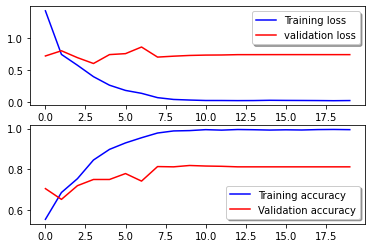

In [80]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)

ax[0].plot(h.history['loss'], color='b', label="Training loss")
ax[0].plot(h.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(h.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)